**Sentiment Analysis using BERT , CNN,  BERT+CNN in Tensorflow**

 I am going to apply CNN , BERT, CNN+BERT MOodels to compute vector-space representations of a IMDB dataset which has two class
 
 1- **Positive:1**

 2- **Negative:0**
 
This notebook has three section. At the **First part** I will: 

*   Load the IMDB dataset
*   Load a **BERT models** from TensorFlow Hub 
*   Build the model by combining BERT with a classifier
*   Train the model, fine-tuning BERT as part of that
*   Save the model

**Second Part**
*   Build the Convolutional Neural Network Model
*   Train , evaluate the model using Confusion Matrix
*   Save the model 

**Third part**
Includes using the pretreined BERT to compute vector-space representations of the IMDB dataset to feed to **CNN** downsteam Archtectures.




# **First section**

**About BERT**

BERT (article link [link text](https://arxiv.org/abs/1810.04805)) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.


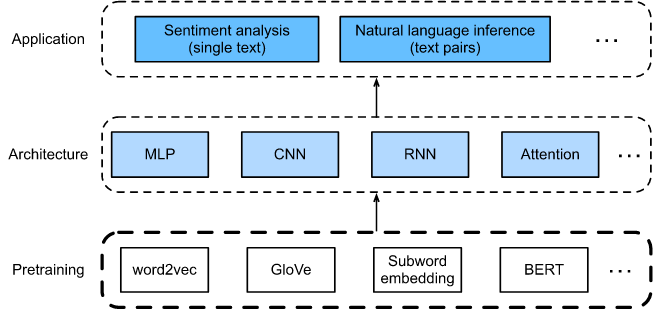



Source: http://www.d2l.ai/chapter_natural-language-processing-pretraining/index.html



**Installing dependencies and importing packages**

In [1]:
!pip install 'tensorflow==2.8.0'

     |████████████████████████████████| 462 kB 5.4 MB/s 


In [2]:
pip install 'tf-estimator-nightly==2.8.0.dev2021122109'

In [3]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 67 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 34.2 MB/s 
     |████████████████████████████████| 895 kB 22.4 MB/s 
     |████████████████████████████████| 6.5 MB 17.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [5]:
!pip install tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 234 kB 30.1 MB/s 
     |████████████████████████████████| 47.8 MB 104 kB/s 
     |████████████████████████████████| 1.1 MB 17.6 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 90 kB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 352 kB 33.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=689fd59036832def250be6db6ef36b381baab2c706f5b13f858f2a6205b40c44
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6c45762c339c624ed6fe02d3562fc3bf828ed1ba49c73b20785e5372d3078013
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b1

In [6]:
import os
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.stats import spearmanr

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers


from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules


import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks




from tqdm.notebook import tqdm

import math
from math import floor, ceil

from transformers import *




In [7]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [8]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

In [9]:
np.set_printoptions(suppress=True)
print(tf.__version__)


2.8.0


**Loading and preparing the dataset**

In [10]:

df = pd.read_csv('/content/IMDB Dataset500.csv')

In [11]:
nRowsRead = None # specify 'None' if want to read whole file
df0 = pd.read_csv('/content/IMDB Dataset500.csv', delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'IMDB Dataset.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 500 rows and 2 columns


In [12]:
df0.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
#Doing some adjustments
c=df0['sentiment']
df0.rename(columns={'review' : 'text',
                   'sentiment' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({'positive': 1, 'negative': 0})

df= pd.concat([a,b,c], axis=1)
df

,text,category,sentiment
0,One of the other reviewers has mentioned that ...,1,positive
1,A wonderful little production. <br /><br />The...,1,positive
2,I thought this was a wonderful way to spend ti...,1,positive
3,Basically there's a family where a little boy ...,0,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive
...,...,...,...
495,"""American Nightmare"" is officially tied, in my...",0,negative
496,"First off, I have to say that I loved the book...",0,negative
497,This movie was extremely boring. I only laughe...,0,negative
498,I was disgusted by this movie. No it wasn't be...,0,negative


In [14]:
df.rename(columns={'sentiment' : 'category',
                   'category':'label'}, 
                    inplace=True)


In [15]:
df.head()

,text,label,category
0,One of the other reviewers has mentioned that ...,1,positive
1,A wonderful little production. <br /><br />The...,1,positive
2,I thought this was a wonderful way to spend ti...,1,positive
3,Basically there's a family where a little boy ...,0,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,positive


In [16]:
# Grouping data by label
df.groupby('label').count()

,text,category
label,,
0,263,263
1,237,237


In [17]:
y=df['label']

**Splitting the dataset between training and test set**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],y,
    test_size=0.33,
    random_state=42, 
    stratify=y   
)

In [19]:
X_train = pd.DataFrame(X_train)

In [20]:
y_train = pd.DataFrame(y_train)

In [21]:
df_train= pd.concat([X_train, y_train], axis=1)

In [22]:
df_train.head()

,text,label
360,The endless bounds of our inhumanity to our ow...,1
499,Such a joyous world has been created for us in...,1
436,This is an excellent film about the characters...,1
290,"I saw the movie ""Hoot"" and then I immediately ...",1
408,I watched this movie based on the good reviews...,0


In [23]:
X_test = pd.DataFrame(X_test)

In [24]:
y_test = pd.DataFrame(y_test)

In [25]:
df_test= pd.concat([X_test, y_test], axis=1)

In [26]:
df_test.head()

,text,label
271,This is a must-see documentary movie for anyon...,1
127,"The complaints are valid, to me the biggest pr...",0
270,"Clifton Webb is one of my favorites. However, ...",0
64,An unmarried woman named Stella (Bette Midler)...,0
62,So let's begin!)))<br /><br />The movie itself...,1


**Splitting the data between train and test sets:**

 **Showing the more frequent words in each class using Wordcloud**

In [27]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT") 
stopwords.add("one")
stopwords.add("movie")
stopwords.add("film")
stopwords.add("br")
stopwords.add("things")
stopwords.add("watched")
stopwords.add("little")
stopwords.add("must")
stopwords.add("seen")
stopwords.add("Basically")
stopwords.add("plot")
stopwords.add("well")
print(type(STOPWORDS))

<class 'set'>


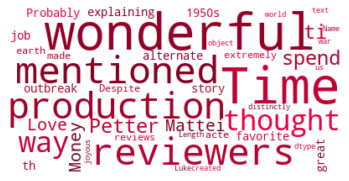

In [28]:


import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="positive"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

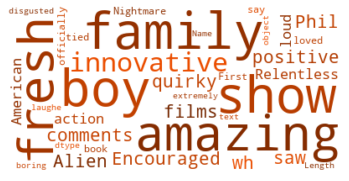

In [29]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="negative"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

**Build TensorFlow input**

[Reference ](https://www.tensorflow.org/guide/data)

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

While **tf.data** tries to propagate shape information, the default settings of Dataset.batch result is an unknown batch size because the last batch may not be full. Note the Nones in the shape


Use the drop_remainder argument to ignore that last batch, and get full shape propagation

In [31]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Loading models from TensorFlow Hub**

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/nlp/bert which L is used as a number of hidden layers and H as hidden size of H, and A as attention heads.


Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

[BERT-Base, Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.

[The Small BERT models](https://tfhub.dev/google/collections/bert/1) are instances of the original BERT architecture with a smaller number L of layers (i.e., residual blocks) combined with a smaller hidden size H and a matching smaller number A of attention heads.

[ALBERT: ](https://tfhub.dev/google/collections/albert/1)four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.

[Reference](https://huggingface.co/google/bert_uncased_L-4_H-256_A-4) 

In [33]:
#@title Choose a BERT model to fine-tune

bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8" #@param ["bert_en_uncased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-512_A-8", "albert_en_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**Preprocessing the model**

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. **TensorFlow Hub** provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

So, the preprocessing model will be loaded into a **hub.KerasLayer** to compose the fine-tuned model. 

In [34]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

**EX)** Let's try the preprocessing model on some text and see the output:

In [35]:
text_test = ['Some films just simply should not be remade']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2070  3152  2074  3432  2323  2025  2022 26943   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use

**(input_words_id, input_mask and input_type_ids)**

The input is truncated to **128 tokens**. BERT has a constraint on the maximum length of a sequence after tokenizing. For any BERT model, the maximum sequence length after tokenization is 512.

**The input_type_ids** only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

**The input masks** is the mask of the words in a sentence – all masks starts with CLF token and SEP token.So the masked array is of size sentence size + 2. The token is defined for CLF – 101 and SEP – 102 and .Also the input mask is 1 for useful tokens,and 0 for padding. 

**The input_words_ids** has the token ids of the input sequences and gives unique id’s for individual words. Each word is encoded(ids can be from a vocabulary), padded and separated Length.

**text_preprocessed**

To generate embedding now all we need to do is to pass this text_preprocessed to the encoder. 

In [36]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [37]:
bert_results = bert_model(text_preprocessed)

In [38]:

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9801589  -0.9029618   0.05205656  0.1453221   0.06510507  0.9621157
  0.9908325  -0.98905075 -0.07747438 -0.9548365  -0.19989365 -0.992779  ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.5643114   0.03142864 -0.38152346 ... -0.0927501   1.3296249
   0.30178115]
 [-0.6749956   1.075004   -0.8783495  ... -0.08735946 -1.4268557
   0.6026988 ]
 [-0.2031816   0.46061942 -0.99649775 ...  0.86681235  0.746163
   1.5390762 ]
 ...
 [-0.05733637 -0.16234955  0.21491235 ... -0.06549064  0.8769871
   1.2401373 ]
 [ 0.28114188 -0.1666598  -0.32903212 ...  0.18311548  1.4608147
   0.63959897]
 [-0.10031244 -0.08610195 -0.06985556 ...  0.34557703  1.1300983
   0.60532635]]


The BERT models return a map with 3 important keys: **pooled_output, sequence_output, encoder_outputs:**

**pooled_output** represents each input sequence as a whole. The shape is **[batch_size, H]**. You can think of this as an embedding for the entire movie review.

**sequence_output** represents each input token in the context. The shape is **[batch_size, seq_length, H**]. You can think of this as a contextual embedding for every token in the movie review.

**encoder_outputs** are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape **[batch_size, seq_length, 1024]** with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

**Define the model**

The fine-tuned model will be created with the preprocessing model, and the selected BERT model, one Dense and a Dropout layer.

In [39]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [40]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6084119]], shape=(1, 1), dtype=float32)


tf.sigmoid Computes sigmoid of x element-wiseand it measures the probability error in discrete classification tasks in which each class is independent and not mutually exclusive.If a positive number is large, then its sigmoid will approach to 1 since the formula If a negative number is large, its sigmoid will approach to 0. [Reference](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) 

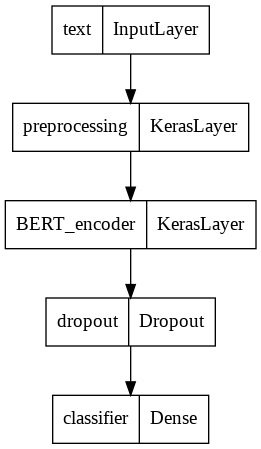

In [41]:
tf.keras.utils.plot_model(classifier_model)

**Model training**

I now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

**Loss function**

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), I'll use losses.BinaryCrossentropy loss function.

In [42]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

**Optimizer**

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), I will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [43]:
from official.nlp import optimization

In [44]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

**Loading the BERT model and training**

In [45]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [46]:
print(f'Training model with {tfhub_handle_encoder}')
BERT_history = classifier_model.fit(x=train_ds,
                               validation_data=(X_test, y_test),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
11/11 [==============================] - 111s 9s/step - loss: 0.7222 - binary_accuracy: 0.5373 - val_loss: 0.6031 - val_binary_accuracy: 0.6424
Epoch 2/5
11/11 [==============================] - 99s 9s/step - loss: 0.5867 - binary_accuracy: 0.6358 - val_loss: 0.5473 - val_binary_accuracy: 0.7030
Epoch 3/5
11/11 [==============================] - 99s 9s/step - loss: 0.5135 - binary_accuracy: 0.7134 - val_loss: 0.5163 - val_binary_accuracy: 0.7091
Epoch 4/5
11/11 [==============================] - 98s 9s/step - loss: 0.4584 - binary_accuracy: 0.7254 - val_loss: 0.4966 - val_binary_accuracy: 0.7212
Epoch 5/5
11/11 [==============================] - 98s 9s/step - loss: 0.4230 - binary_accuracy: 0.8030 - val_loss: 0.4879 - val_binary_accuracy: 0.7697


**Evaluate the model**

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [47]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

6/6 [==============================] - 13s 2s/step - loss: 0.4879 - binary_accuracy: 0.7697
Loss: 0.4878818392753601
Accuracy: 0.7696969509124756


In [48]:
y_predict_BERT =  classifier_model.predict(test_ds)


In [49]:
y_predict_BERT.shape

(165, 1)

In [50]:
y_BERT = classifier_model(tf.constant(df_test.text.values))

In [51]:
y_BERT

<tf.Tensor: shape=(165, 1), dtype=float32, numpy=
array([[ 1.9485708 ],
       [-0.533026  ],
       [ 1.2600586 ],
       [-1.0861561 ],
       [ 0.5887116 ],
       [-1.3619448 ],
       [ 0.58905333],
       [ 0.22673586],
       [-0.96339655],
       [-0.21272314],
       [-0.99491537],
       [-1.5492028 ],
       [-1.5363625 ],
       [ 1.4349633 ],
       [ 0.5732    ],
       [ 1.4814341 ],
       [ 2.0948374 ],
       [-0.55763924],
       [-2.2170484 ],
       [ 0.03608537],
       [ 2.0910122 ],
       [-2.104291  ],
       [-1.7043823 ],
       [ 1.0370339 ],
       [-0.7596377 ],
       [ 1.1885377 ],
       [ 1.0594066 ],
       [-1.7400908 ],
       [ 0.25957438],
       [ 0.6976651 ],
       [ 1.1204194 ],
       [-0.11979093],
       [-1.250957  ],
       [ 0.6469413 ],
       [-1.6253114 ],
       [-1.126125  ],
       [-0.28790918],
       [ 0.5148293 ],
       [ 1.225327  ],
       [ 1.8315085 ],
       [ 1.2638737 ],
       [-1.942691  ],
       [-0.19270837],
    

In [52]:
cutoff = 0.6                         
y_pred_classes = np.zeros_like(y_predict_BERT)    
y_pred_classes[y_predict_BERT > cutoff] = 1  

In [53]:
y_test_classes = np.zeros_like(y_BERT)
y_test_classes[y_BERT > cutoff] = 1

**Plot the accuracy and loss over time**

Based on the History object returned by model.fit() the training and validation loss can be plotted for comparison, as well as the training and validation accuracy.

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

Text(33.0, 0.5, 'y_pred')

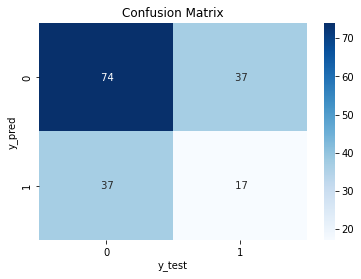

In [54]:
cm=confusion_matrix(y_test_classes, y_pred_classes)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [55]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67       111
         1.0       0.31      0.31      0.31        54

    accuracy                           0.55       165
   macro avg       0.49      0.49      0.49       165
weighted avg       0.55      0.55      0.55       165



dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


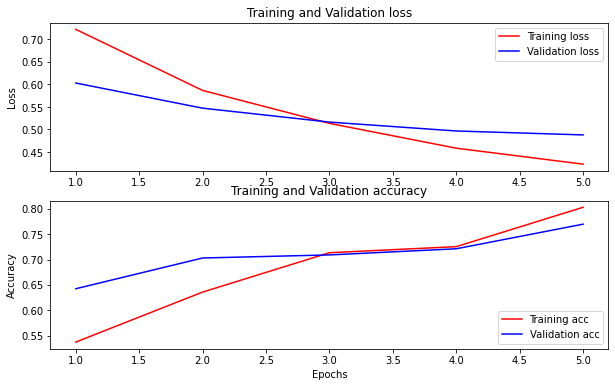

In [56]:
history_dict = BERT_history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Export for inference**

Now the fine-tuned model will be saved for later use.

In [57]:
dataset_name = 'BERT_IMDB'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./BERT_IMDB_bert/assets


INFO:tensorflow:Assets written to: ./BERT_IMDB_bert/assets


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [58]:
BERT_reloaded_model = tf.saved_model.load(saved_model_path)

# **CNN**

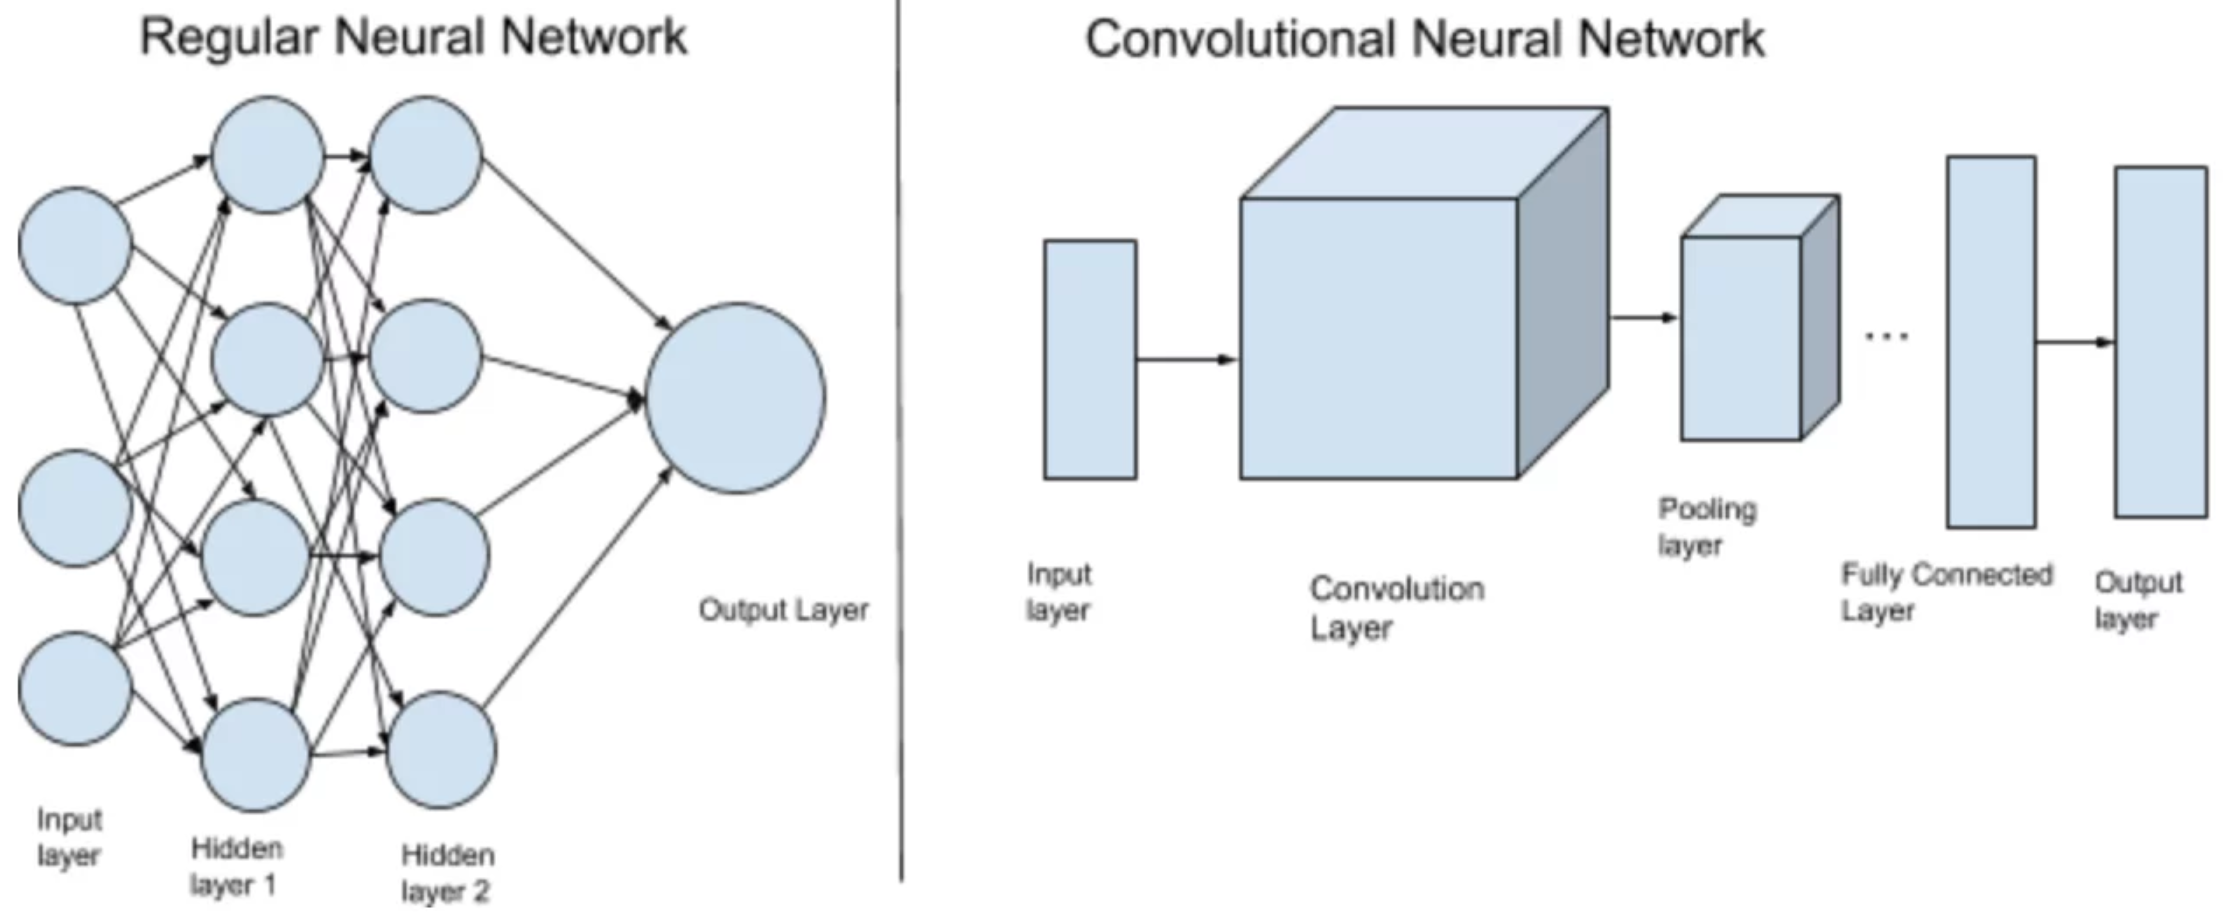

https://www.topcoder.com/blog/convolutional-neural-networks-in-pytorch/


**CNN Architecture**

There are three main types of layers in CNN architecture:

**Convolutional Layer**: The job of the convolutional layer is feature extraction. It learns to find spatial features in an input image. This layer is produced by applying a series of different image filters to an input image. These filters are known as convolutional kernels. A filter is a small grid of values that slides over the input image pixel by pixel to produce a filtered output image that will be of the same size as the input image.

**Pooling Layer**: After the convolutional layer comes the pooling layer; the most common type of pooling layer is maxpooling layer. The main goal of the pooling layer is dimensionality reduction, meaning reducing the size of an image by taking the max value from the window. A maxpooling operation breaks an image into smaller patches. A maxpooling layer is defined by a patch size and stride.

**Fully Connected Layer** : The last layer in CNN is the fully connected layer. Fully connected means that every output that’s produced at the end of the last pooling layer is an input to each node in this fully connected layer.The role of the fully connected layer is to produce a list of class scores and perform classification based on image features that have been extracted by the previous convolutional and pooling layers. So, the last fully connected layer will have as many nodes as there are classes

In [59]:
df_CNN = df[['label','text']]
df_CNN.head()

,label,text
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


In [60]:
y_CNN=df_CNN['label']

In [61]:
from sklearn.model_selection import train_test_split
df_CNN_train,df_CNN_test,y_CNN_train,y_CNN_test=train_test_split(df_CNN['text'],y_CNN,test_size=0.33,random_state=42)
print('DF Train Shape: ',df_CNN_train.shape)
print('DF Test Shape: ',df_CNN_test.shape)
print('Y Train Shape: ',y_CNN_train.shape)
print('Y Test Shape: ',y_CNN_test.shape)

DF Train Shape:  (335,)
DF Test Shape:  (165,)
Y Train Shape:  (335,)
Y Test Shape:  (165,)


In [62]:
df_CNN_train

471    When I was a younger(oh about 2)I watched Barn...
26     "The Cell" is an exotic masterpiece, a dizzyin...
7      This show was an amazing, fresh & innovative i...
453    Mom should really be given a different title t...
108    Despite later claims, this early-talkie melodr...
                             ...                        
106    The performance of every actor and actress (in...
270    Clifton Webb is one of my favorites. However, ...
348    Most of the comments on this movie are positiv...
435    You wear only the best Italian suits from Arma...
102    I bought this game on an impulse buy from walm...
Name: text, Length: 335, dtype: object

In [63]:
y_CNN_train

471    0
26     1
7      0
453    1
108    1
      ..
106    1
270    0
348    0
435    1
102    1
Name: label, Length: 335, dtype: int64

In [64]:
df_CNN_test

361    This flick is so bad its beyond belief.Even fo...
73     I am not a golf fan by any means. On May 26 ab...
374    A Compelling Thriller!!, 10 December 2005 Auth...
155    In the standard view, this is a purely awful m...
104    It is easy to tell early in this movie exactly...
                             ...                        
110    Apparently, the people that wrote the back of ...
318    Every high praise word fell way short before t...
428    I never fell asleep during a movie. Never. Thi...
29     'War movie' is a Hollywood genre that has been...
437    This mostly routine fact-based TV drama gets a...
Name: text, Length: 165, dtype: object

In [65]:
y_CNN_test

361    0
73     1
374    1
155    0
104    0
      ..
110    0
318    1
428    0
29     1
437    1
Name: label, Length: 165, dtype: int64

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_CNN_train)
sequence_train=tokenizer.texts_to_sequences(df_CNN_train)
sequence_test=tokenizer.texts_to_sequences(df_CNN_test)

In [67]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 10796 number of independent tokens


In [68]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(335, 1025)

In [69]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(165, 1025)

In [70]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1025)]            0         
                                                                 
 embedding (Embedding)       (None, 1025, 20)          215940    
                                                                 
 conv1d (Conv1D)             (None, 1023, 32)          1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 341, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 339, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 113, 64)          0         
 1D)                                                       

In [71]:
#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#metrics = tf.metrics.BinaryAccuracy()


In [72]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:

CNN_history = model.fit(data_train,y_CNN_train,validation_data=(data_test,y_CNN_test),epochs=30,batch_size=100)

Epoch 1/30
4/4 [==============================] - 3s 521ms/step - loss: 1.5500 - accuracy: 0.4776 - val_loss: 1.4552 - val_accuracy: 0.4848
Epoch 2/30
4/4 [==============================] - 1s 379ms/step - loss: 1.3989 - accuracy: 0.5493 - val_loss: 1.2761 - val_accuracy: 0.4364
Epoch 3/30
4/4 [==============================] - 1s 376ms/step - loss: 1.1941 - accuracy: 0.5433 - val_loss: 1.0312 - val_accuracy: 0.4788
Epoch 4/30
4/4 [==============================] - 2s 383ms/step - loss: 0.9445 - accuracy: 0.7463 - val_loss: 0.8151 - val_accuracy: 0.4848
Epoch 5/30
4/4 [==============================] - 2s 422ms/step - loss: 0.7592 - accuracy: 0.5463 - val_loss: 0.7330 - val_accuracy: 0.4848
Epoch 6/30
4/4 [==============================] - 1s 369ms/step - loss: 0.6926 - accuracy: 0.5463 - val_loss: 0.7044 - val_accuracy: 0.4848
Epoch 7/30
4/4 [==============================] - 2s 453ms/step - loss: 0.6752 - accuracy: 0.5463 - val_loss: 0.7042 - val_accuracy: 0.4848
Epoch 8/30
4/4 [====

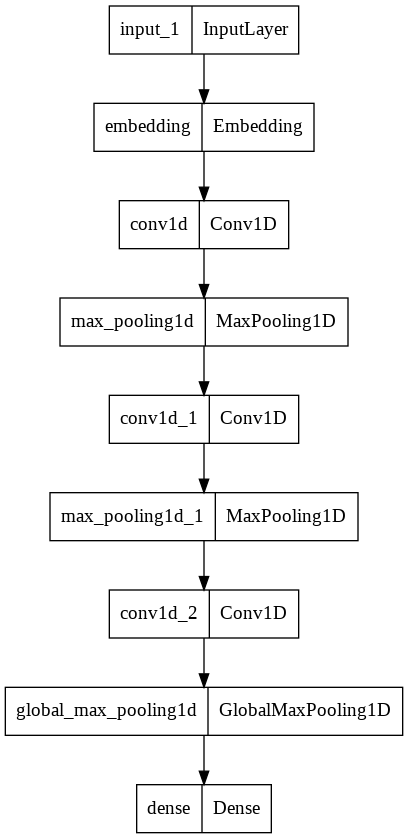

In [74]:
tf.keras.utils.plot_model(model)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


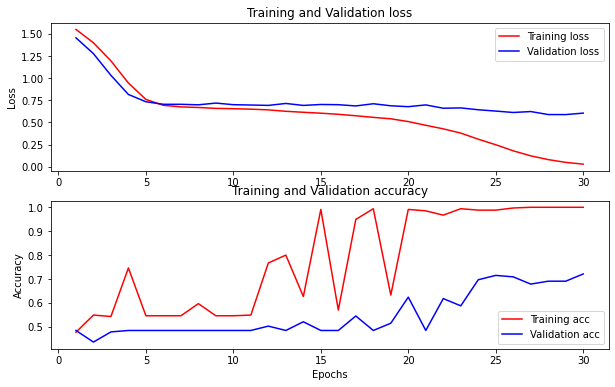

In [76]:
history_dict = CNN_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [77]:
y_CNN_pred=model.predict(data_test)


In [78]:
y_CNN_pred.shape


(165, 5)

In [79]:
y_CNN_pred=np.argmax(y_CNN_pred,axis=1)


In [80]:
y_CNN_pred

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1])

In [81]:
y_CNN_test

361    0
73     1
374    1
155    0
104    0
      ..
110    0
318    1
428    0
29     1
437    1
Name: label, Length: 165, dtype: int64

Text(33.0, 0.5, 'y_pred')

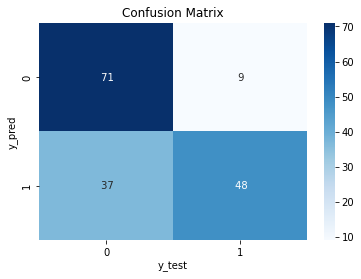

In [82]:
cm=confusion_matrix(y_CNN_test,y_CNN_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [83]:
print(classification_report(y_CNN_test,y_CNN_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76        80
           1       0.84      0.56      0.68        85

    accuracy                           0.72       165
   macro avg       0.75      0.73      0.72       165
weighted avg       0.75      0.72      0.71       165



**Export for inference**

Now the model will be saved for later use.

In [107]:
dataset_name = 'CNN_IMDB'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./CNN_IMDB_bert/assets


INFO:tensorflow:Assets written to: ./CNN_IMDB_bert/assets


In [108]:
CNN_reloaded_model = tf.saved_model.load(saved_model_path)

In [109]:
CNN_reloaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f6a46549550>

# **BERT + CNN**

For the implementation with CNN, I am using the sequence_output as input to the convolutional layer. It represents each input token in the context. **The shape is [batch_size, seq_length, H].** You can think of this as a contextual embedding for every token in the text. This outputs saves positional information about the inputs, then it would male cense to feed a convolutional layer.

In [86]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
      
    
    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    
    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
#    net = tf.keras.layers.Flatten()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

**ReLU** stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x). It is linear (identity) for all positive values, and zero for all negative values.

Also, **tf.keras.layers.Conv1D** creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. [Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) 

**Tf.keras.layers.GlobalMaxPool1D()** downsamples the input representation by taking the maximum value over the time dimension.[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)


The **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.[Reference ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)


**Dense** implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.[Reference ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [87]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6016522  0.5735337  0.57232964]], shape=(1, 3), dtype=float32)


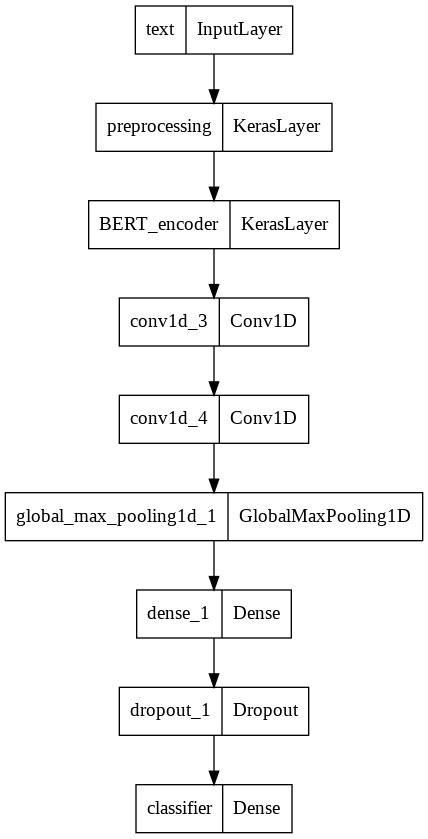

In [88]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [89]:
cnn_classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [90]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
metrics = tf.metrics.Accuracy()

In [91]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

Defining the weights for BERT+CNN the model.

In [92]:
#This is an balanced dataset.
positive, negative = np.bincount(df['label'])
total = positive + negative 
print('Examples:\n    Total: {}\n    positive: {} ({:.2f}% of total)\n'.format(
    total, positive, 100 * positive / total))
print('Examples:\n    Total: {}\n    negative: {} ({:.2f}% of total)\n'.format(
    total, negative, 100 * negative / total))


Examples:
    Total: 500
    positive: 263 (52.60% of total)

Examples:
    Total: 500
    negative: 237 (47.40% of total)



In [93]:
weight_for_0 = (1 /positive)*(total)/2.0 
weight_for_1 = (1 / negative)*(total)/2.0



class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.95
Weight for class 1: 1.05


In [94]:

print(f'Training model with {tfhub_handle_encoder}')
BERTCNN_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=(X_test, y_test),
                                       epochs=epochs,
                                       class_weight=class_weight
                                       
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.5284

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 116s 10s/step - loss: 0.9567 - accuracy: 0.5284 - val_loss: 0.8201 - val_accuracy: 0.5455
Epoch 2/10
11/11 [==============================] - 99s 9s/step - loss: 0.8047 - accuracy: 0.4567 - val_loss: 0.7324 - val_accuracy: 0.5455
Epoch 3/10
11/11 [==============================] - 99s 9s/step - loss: 0.7303 - accuracy: 0.5642 - val_loss: 0.7079 - val_accuracy: 0.5515
Epoch 4/10
11/11 [==============================] - 99s 9s/step - loss: 0.6974 - accuracy: 0.5881 - val_loss: 0.6895 - val_accuracy: 0.6303
Epoch 5/10
11/11 [==============================] - 99s 9s/step - loss: 0.6541 - accuracy: 0.6806 - val_loss: 0.6736 - val_accuracy: 0.6606
Epoch 6/10
11/11 [==============================] - 99s 9s/step - loss: 0.6349 - accuracy: 0.6896 - val_loss: 0.6625 - val_accuracy: 0.6909
Epoch 7/10
11/11 [==============================] - 99s 9s/step - loss: 0.6208 - accuracy: 0.6896 - val_loss: 0.6517 - val_accuracy: 0.7030
Epoch 8/10
11/11 [===========

In [95]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 13s 2s/step - loss: 0.6346 - accuracy: 0.7333
Loss: 0.6345964074134827
Accuracy: 0.7333333492279053


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


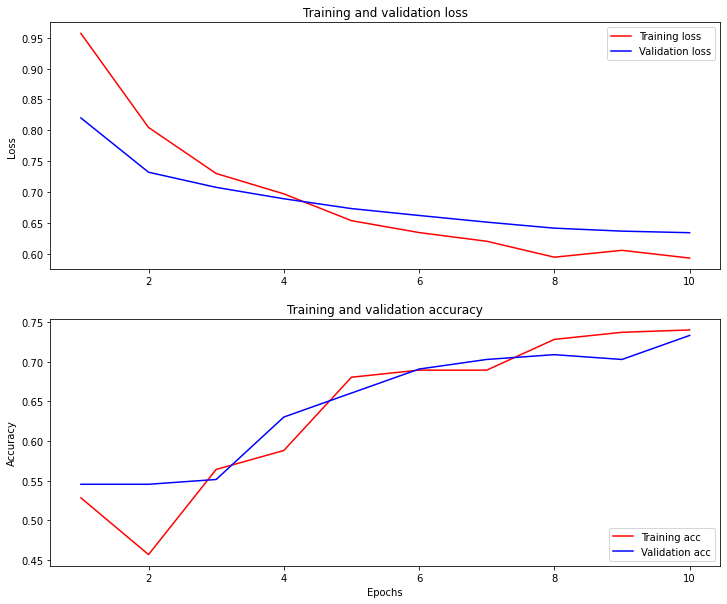

In [96]:
history_dict = BERTCNN_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [97]:
y_BERTCNN_pred=cnn_classifier_model.predict(test_ds)
y_BERTCNN_pred

array([[0.51748145, 0.46917173, 0.01334682],
       [0.4159896 , 0.57231104, 0.01169933],
       [0.6094717 , 0.37431052, 0.01621779],
       [0.6522439 , 0.33359507, 0.01416104],
       [0.49771175, 0.48990306, 0.01238512],
       [0.42457417, 0.5623437 , 0.01308212],
       [0.48770234, 0.49485642, 0.01744122],
       [0.42688042, 0.558683  , 0.01443666],
       [0.38599354, 0.6038825 , 0.010124  ],
       [0.58803105, 0.40239063, 0.00957839],
       [0.61382264, 0.37413543, 0.0120419 ],
       [0.47358692, 0.51678985, 0.00962321],
       [0.43904966, 0.54651976, 0.01443067],
       [0.48067474, 0.5073593 , 0.01196596],
       [0.5025619 , 0.49052846, 0.00690969],
       [0.47595075, 0.5155153 , 0.00853394],
       [0.6588945 , 0.32471603, 0.01638948],
       [0.46072972, 0.52504456, 0.01422563],
       [0.564348  , 0.42005724, 0.01559487],
       [0.6527233 , 0.338229  , 0.00904763],
       [0.5092842 , 0.48137832, 0.00933754],
       [0.50624394, 0.48110443, 0.01265161],
       [0.

In [98]:
y_BERTCNN_pred=np.argmax(y_BERTCNN_pred,axis=1)
y_BERTCNN_pred

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

Text(33.0, 0.5, 'y_pred')

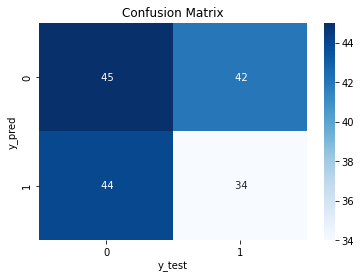

In [99]:
cm=confusion_matrix(y_test,y_BERTCNN_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [100]:
print(classification_report(y_CNN_test,y_CNN_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76        80
           1       0.84      0.56      0.68        85

    accuracy                           0.72       165
   macro avg       0.75      0.73      0.72       165
weighted avg       0.75      0.72      0.71       165



**Export for inference**

Now we just save the fine-tuned model for later use


In [101]:
dataset_name = 'BERTCNN_IMDB'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

cnn_classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./BERTCNN_IMDB_bert/assets


INFO:tensorflow:Assets written to: ./BERTCNN_IMDB_bert/assets


In [102]:
BERT_CNN_reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test the model on any sentence you want, just add to the examples variable below.

In [103]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!', 
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]


In [115]:
#CNN_reloaded_result = tf.sigmoid(CNN_reloaded_model(tf.constant(examples)))

In [116]:
BERT_reloaded_results = tf.sigmoid(BERT_reloaded_model(tf.constant(examples)))

In [117]:
BERTCNN_reloaded_results = tf.sigmoid(BERT_CNN_reloaded_model(tf.constant(examples)))

In [118]:
# print('Results from the CNN model:')
# print_my_examples(examples, CNN_reloaded_results)


print('Results from the BERT model:')
print_my_examples(examples, BERT_reloaded_results)

print('Results from the BERTCNN model :')
print_my_examples(examples, BERTCNN_reloaded_results)

#print('Results from the model in memory:')
#print_my_examples(examples, original_results)

Results from the BERT model:
input: this is such an amazing movie! : score: 0.871721
input: The movie was great!           : score: 0.640763
input: The movie was meh.             : score: 0.660278
input: The movie was okish.           : score: 0.694434
input: The movie was terrible...      : score: 0.372601

Results from the BERTCNN model :
input: this is such an amazing movie! : score: 0.622488
input: The movie was great!           : score: 0.611779
input: The movie was meh.             : score: 0.593441
input: The movie was okish.           : score: 0.605346
input: The movie was terrible...      : score: 0.633656

